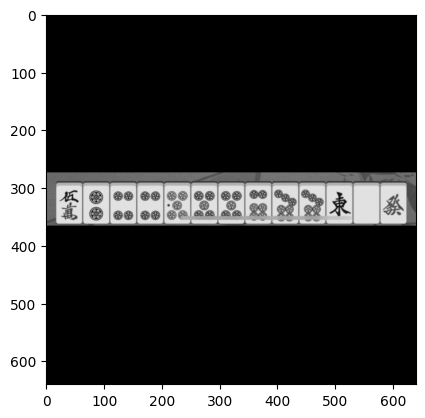

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from typing import Tuple, NamedTuple


class PaddingInfo(NamedTuple):
    scale: float
    pad_x: int
    pad_y: int
    original_height: int
    original_width: int


def preprocess_image(input_image: Image.Image) -> Tuple[Image.Image, PaddingInfo]:
    """
    图像预处理流程：
    1. 转换为灰度图
    2. 对比度拉伸
    3. 等比缩放并填充到640x640
    """
    # 步骤1: 灰度化
    gray_image = convert_to_grayscale(input_image)

    # 步骤2: 对比度拉伸
    contrast_image = stretch_contrast(gray_image)

    # 步骤3: 等比缩放并填充
    padded_image, padding_info = scale_and_pad_to_square(contrast_image, 640, (0, 0, 0))

    return padded_image, padding_info


def convert_to_grayscale(image: Image.Image) -> Image.Image:
    """使用Pillow的convert方法实现灰度化"""
    return image.convert("L")  # 'L'模式表示8位灰度图


def stretch_contrast(image: Image.Image) -> Image.Image:
    """对比度拉伸（直方图均衡化）"""
    return ImageOps.autocontrast(image)


def scale_and_pad_to_square(image: Image.Image, target_size: int, background_color: Tuple[int, int, int]) -> Tuple[Image.Image, PaddingInfo]:
    """
    等比缩放并填充到目标尺寸
    :param image: 输入图像(Pillow Image)
    :param target_size: 目标正方形边长
    :param background_color: 填充背景色(RGB)
    :return: (处理后的图像, PaddingInfo)
    """
    # 计算缩放比例
    original_width, original_height = image.size
    scale = target_size / max(original_width, original_height)

    # 计算缩放后的尺寸
    scaled_width = int(original_width * scale)
    scaled_height = int(original_height * scale)

    # 计算填充位置
    pad_x = (target_size - scaled_width) // 2
    pad_y = (target_size - scaled_height) // 2

    # 缩放图像
    scaled_image = image.resize((scaled_width, scaled_height), Image.BILINEAR)

    # 创建新图像并填充
    if image.mode == "L":  # 灰度图
        squared_image = Image.new("L", (target_size, target_size), color=background_color[0])
    else:  # 彩色图
        squared_image = Image.new("RGB", (target_size, target_size), color=background_color)

    # 粘贴缩放后的图像到中心
    squared_image.paste(scaled_image, (pad_x, pad_y))

    # 返回处理后的图像和填充信息
    padding_info = PaddingInfo(scale=scale, pad_x=pad_x, pad_y=pad_y, original_height=original_height, original_width=original_width)

    return squared_image, padding_info

img = Image.open("image.png")
img, padding_info = preprocess_image(img)
plt.imshow(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

In [18]:
CLASS_NAMES = [
    "1m",
    "1p",
    "1s",
    "2m",
    "2p",
    "2s",
    "3m",
    "3p",
    "3s",
    "4m",
    "4p",
    "4s",
    "5m",
    "5p",
    "5s",
    "6m",
    "6p",
    "6s",
    "7m",
    "7p",
    "7s",
    "8m",
    "8p",
    "8s",
    "9m",
    "9p",
    "9s",
    "chun",
    "haku",
    "hatsu",
    "nan",
    "pe",
    "sha",
    "tou",
]

In [19]:
import onnxruntime as ort

def create_input_tensor(img: Image.Image):
    return (
        np.array(img.convert("RGB"), dtype=np.float32).transpose(2, 0, 1)[np.newaxis, ...] / 255.0
    )  # 添加batch维度并归一化


session = ort.InferenceSession('runs/detect/train2/weights/best.onnx')
input_name = session.get_inputs()[0].name

# 推理
outputs = session.run(None, {input_name: create_input_tensor(img).astype(np.float16)})
print(outputs[0].shape)

(1, 38, 8400)


In [20]:
from typing import NamedTuple


class Detection(NamedTuple):
    x1: int
    y1: int
    x2: int
    y2: int
    class_id: int
    confidence: float
    
def postprocess(
    output: np.ndarray,
    padding: PaddingInfo,
    num_classes: int,
    conf_threshold: float = 0.5,
    iou_threshold: float = 0.5,
) -> list[Detection]:
    """
    YOLOv8 后处理 (纯NumPy实现)

    参数:
        output: 模型输出数组 [84, 8400]
        padding: 预处理时的填充信息
        num_classes: 类别数
        conf_threshold: 置信度阈值
        iou_threshold: NMS的IoU阈值

    返回:
        List[Detection]: 过滤后的检测结果
    """
    # 1. 检查输出形状
    if output.shape != (84, 8400) and output.shape != (4 + num_classes, 8400):
        raise ValueError(
            f"非法输出格式，预期[84,8400]或[{4 + num_classes},8400]，实际{output.shape}"
        )

    # 2. 提取框数据 (xc, yc, w, h)
    boxes = output[:4].T  # [8400, 4]

    # 3. 提取类别置信度并找到最大置信度类别
    class_confs = output[4 : 4 + num_classes].T  # [8400, num_classes]
    max_conf = np.max(class_confs, axis=1)  # [8400,]
    class_ids = np.argmax(class_confs, axis=1)  # [8400,]

    # 4. 过滤低置信度检测
    mask = max_conf > conf_threshold
    boxes = boxes[mask]
    class_ids = class_ids[mask]
    max_conf = max_conf[mask]

    if len(boxes) == 0:
        return []

    # 5. 转换到原始图像坐标 (补偿填充和缩放)
    xc, yc, w, h = boxes.T  # 分别获取所有框的xc,yc,w,h

    # 计算原始坐标 (一次性向量化计算)
    x1 = ((xc - w / 2 - padding.pad_x) / padding.scale).clip(0, padding.original_width)
    y1 = ((yc - h / 2 - padding.pad_y) / padding.scale).clip(0, padding.original_height)
    x2 = ((xc + w / 2 - padding.pad_x) / padding.scale).clip(0, padding.original_width)
    y2 = ((yc + h / 2 - padding.pad_y) / padding.scale).clip(0, padding.original_height)

    # 转换为整数坐标
    boxes_orig = np.stack([x1, y1, x2, y2], axis=1).astype(int)

    # 6. 应用非极大抑制 (NMS)
    keep_indices = nms(boxes_orig, max_conf, iou_threshold)

    # 7. 构建最终检测结果
    return [
        Detection(
            x1=int(boxes_orig[i, 0]),
            y1=int(boxes_orig[i, 1]),
            x2=int(boxes_orig[i, 2]),
            y2=int(boxes_orig[i, 3]),
            class_id=int(class_ids[i]),
            confidence=float(max_conf[i]),
        )
        for i in keep_indices
    ]


def nms(boxes: np.ndarray, scores: np.ndarray, iou_threshold: float) -> list[int]:
    """
    非极大抑制实现 (纯NumPy)

    参数:
        boxes: [N, 4] (x1,y1,x2,y2)
        scores: [N,]
        iou_threshold: IoU阈值

    返回:
        保留的检测框索引列表
    """
    # 按置信度降序排序
    order = np.argsort(scores)[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        # 计算当前框与其他框的IoU
        xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])

        inter = np.maximum(0.0, xx2 - xx1) * np.maximum(0.0, yy2 - yy1)
        area_i = (boxes[i, 2] - boxes[i, 0]) * (boxes[i, 3] - boxes[i, 1])
        area_other = (boxes[order[1:], 2] - boxes[order[1:], 0]) * (
            boxes[order[1:], 3] - boxes[order[1:], 1]
        )
        iou = inter / (area_i + area_other - inter)

        # 保留IoU低于阈值的框
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]  # +1 因为order[1:]被使用

    return keep


def calculate_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    """
    计算两个框的IoU (辅助函数)
    """
    xx1 = max(box1[0], box2[0])
    yy1 = max(box1[1], box2[1])
    xx2 = min(box1[2], box2[2])
    yy2 = min(box1[3], box2[3])

    inter = max(0, xx2 - xx1) * max(0, yy2 - yy1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return inter / (area1 + area2 - inter)

detections = postprocess(
    outputs[0][0, ...], padding_info, num_classes=len(CLASS_NAMES)
)
detections.sort(key=lambda x: x.x1)

for d in detections:
    print(f"{CLASS_NAMES[d.class_id]}  {d}")

5m  Detection(x1=44, y1=57, x2=156, y2=224, class_id=12, confidence=0.986328125)
2p  Detection(x1=164, y1=60, x2=274, y2=222, class_id=4, confidence=0.9765625)
4p  Detection(x1=282, y1=61, x2=390, y2=223, class_id=10, confidence=0.98046875)
4p  Detection(x1=399, y1=61, x2=509, y2=221, class_id=10, confidence=0.97021484375)
5p  Detection(x1=519, y1=59, x2=628, y2=217, class_id=13, confidence=0.9091796875)
5p  Detection(x1=634, y1=59, x2=745, y2=203, class_id=13, confidence=0.9365234375)
5p  Detection(x1=751, y1=58, x2=862, y2=203, class_id=13, confidence=0.919921875)
6p  Detection(x1=868, y1=57, x2=981, y2=212, class_id=16, confidence=0.9609375)
7p  Detection(x1=988, y1=59, x2=1099, y2=209, class_id=19, confidence=0.97509765625)
7p  Detection(x1=1106, y1=58, x2=1216, y2=217, class_id=19, confidence=0.9775390625)
tou  Detection(x1=1224, y1=55, x2=1335, y2=220, class_id=33, confidence=0.98876953125)
haku  Detection(x1=1341, y1=56, x2=1452, y2=224, class_id=28, confidence=0.9638671875)
hat